# Manga Emotion Classification

## About the DataSet


*   Pleased (38)
*   Angry (54)
*   Crying (56)
*   Sad (57)
*   Embarrassed (67)
*   Happy (87)
*   Shock (103)




## Obejctive and Reason

Objective
*   The objective of manga emotion image classification is to develop a machine learning model capable of accurately categorizing anime images based on distinct visual features, such as the base of emotion. The model should be able to automatically label and organize a wide variety of anime images into predefined categories, enhancing efficiency and accessibility in anime-related data management.

Reason
*   Manga emeotion image classification is important because it automates the process of organizing and categorizing large volumes of anime content, saving time and ensuring consistency. By using machine learning, it enhances user experiences on platforms by improving searchability and personalized recommendations. Additionally, support to understand human emotion thorugh drawing of managa



## Libarary

In [4]:
import numpy as np
import pandas as pd
import os
import shutil
import random
import cv2
from tqdm import tqdm
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import datasets, layers, models,optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from collections import defaultdict
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB3
import glob
from tensorflow.keras.regularizers import l2

## Importing Data

In [5]:
import kagglehub

kagglehub.login()

In [6]:
# Download latest version
path = kagglehub.dataset_download("mertkkl/manga-facial-expressions")

print("Path to dataset files:", path)

100%|██████████| 17.0M/17.0M [00:01<00:00, 11.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1


## Spliting the Data and Pre-Process

In [7]:
train_path = "/root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1"
test_path = "/root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1"

# For checking if the path exists
print("Train path exists:", os.path.exists(train_path))
print("Test path exists:", os.path.exists(test_path))

# Check contents of the directory
print("Contents of the train directory:", os.listdir(train_path))
print("Contents of the test directory:", os.listdir(test_path))


Train path exists: True
Test path exists: True
Contents of the train directory: ['angry', 'crying', 'shock', 'happy', 'embarrassed', 'pleased', 'sad']
Contents of the test directory: ['angry', 'crying', 'shock', 'happy', 'embarrassed', 'pleased', 'sad']


Shape of training images: (455, 224, 224, 3)
Shape of training labels: (455,)
Shape of testing images: (455, 224, 224, 3)
Shape of testing labels: (455,)


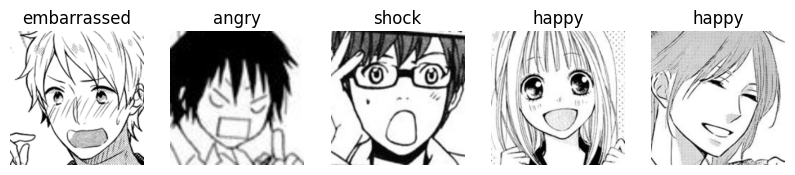

In [8]:
# Define labels and image size
labels = ['angry', 'happy', 'pleased', 'shock', 'embarrassed', 'sad', 'crying']
img_size = 224  # Define the size to resize images

def get_data(data_dir):
    images = []  # List to store image data
    labels_list = []  # List to store labels

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # Get numeric label from label name

        if not os.path.exists(path):
            print(f"Warning: Directory for label '{label}' not found at {path}")
            continue

        for img in os.listdir(path):
            file_ext = img.lower().split('.')[-1]
            if file_ext in ['jpg', 'png']:  # Process only jpg and png files
                try:
                    # Read and process the image
                    img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]  # Convert BGR to RGB
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image

                    # Append the image and its label to respective lists
                    images.append(resized_arr)
                    labels_list.append(class_num)
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
            else:
                print(f"Skipping unsupported file: {img}")

    # Convert lists to numpy arrays
    images = np.array(images)  # Array of images
    labels_list = np.array(labels_list)  # Array of labels

    return images, labels_list

# Example usage:

# Define paths for train and test data
train_path = "/root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1"
test_path = "/root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1"

# Load training and testing data
train_images, train_labels = get_data(train_path)
test_images, test_labels = get_data(test_path)

# Print shapes of the returned data
print(f"Shape of training images: {train_images.shape}")
print(f"Shape of training labels: {train_labels.shape}")
print(f"Shape of testing images: {test_images.shape}")
print(f"Shape of testing labels: {test_labels.shape}")


def visualize_samples(images, labels, num_samples=5):
    """
    Visualize a few sample images along with their labels.
    """
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(labels[idx])
        plt.axis('off')
    plt.show()

# Display random samples from the training data
visualize_samples(train_images, [labels[i] for i in train_labels])



In [9]:
# Function to check the shape of the dataset
def check_data_shape(images, labels, dataset_name):
    print(f"Shape of {dataset_name} images:", images.shape)
    print(f"Shape of {dataset_name} labels:", labels.shape)

    # Print shape of the first image and label
    if len(images) > 0:
        print(f"Shape of first image in {dataset_name}:", images[0].shape)  # Image shape (224, 224, 3)
        print(f"Label of first image in {dataset_name}:", labels[0])  # Label (numeric class)
    else:
        print(f"No images loaded in {dataset_name}.")

# Load the training data
train_images, train_labels = get_data(train_path)

# Load the testing data
test_images, test_labels = get_data(test_path)

# Check the shape of the training data
check_data_shape(train_images, train_labels, "training")

# Check the shape of the testing data
check_data_shape(test_images, test_labels, "testing")


Shape of training images: (455, 224, 224, 3)
Shape of training labels: (455,)
Shape of first image in training: (224, 224, 3)
Label of first image in training: 0
Shape of testing images: (455, 224, 224, 3)
Shape of testing labels: (455,)
Shape of first image in testing: (224, 224, 3)
Label of first image in testing: 0


In [10]:
# Count how many samples there are for each class
# Training labels are stored in the train_labels array

unique_labels, counts = np.unique(train_labels, return_counts=True)

# Loop through the unique labels and counts to display the result
for label, count in zip(unique_labels, counts):
    print(f"Class: {labels[label]}, Count: {count}")



Class: angry, Count: 53
Class: happy, Count: 86
Class: pleased, Count: 37
Class: shock, Count: 102
Class: embarrassed, Count: 66
Class: sad, Count: 56
Class: crying, Count: 55


In [11]:
# Count how many samples there are for each class
# Training labels are stored in the test_labels array

unique_labels, counts = np.unique(test_labels, return_counts=True)

# Loop through the unique labels and counts to display the result
for label, count in zip(unique_labels, counts):
    print(f"Class: {labels[label]}, Count: {count}")


Class: angry, Count: 53
Class: happy, Count: 86
Class: pleased, Count: 37
Class: shock, Count: 102
Class: embarrassed, Count: 66
Class: sad, Count: 56
Class: crying, Count: 55


## EDA

### Statics Image of each Emotion

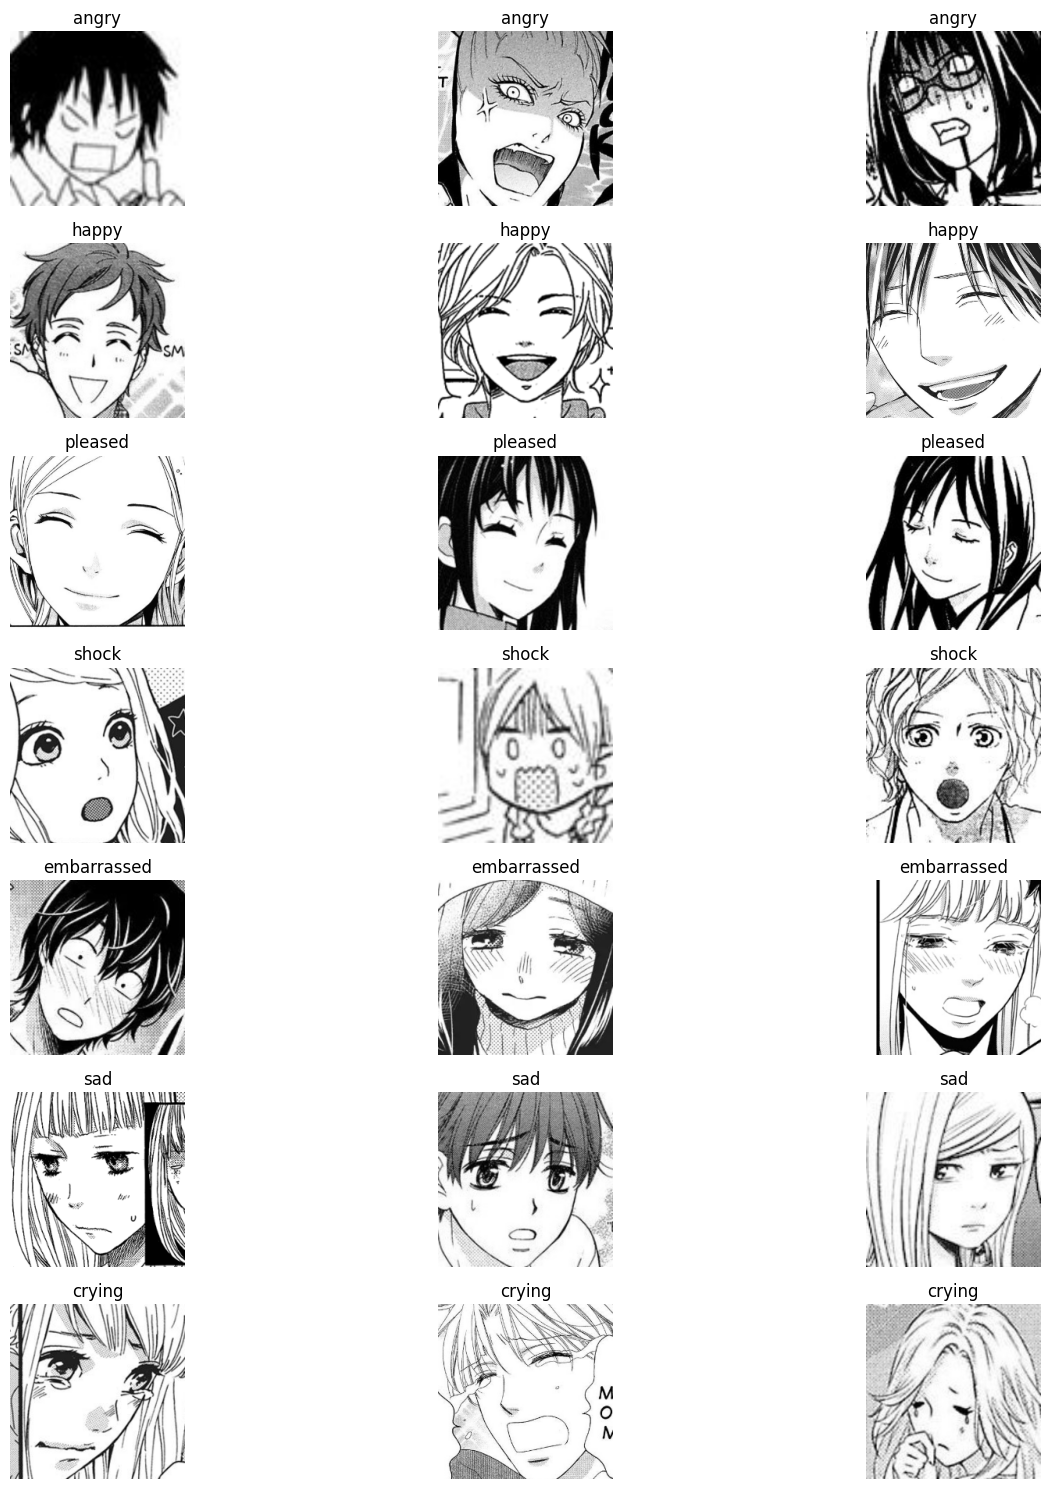

In [12]:
def show_images_from_each_class(images, labels, class_names, num_images_per_class=3):
    # Create a plot with subplots for each class
    fig, axes = plt.subplots(len(class_names), num_images_per_class, figsize=(15, 15))

    for i, label in enumerate(class_names):
        # Get all images that belong to the current class (i.e., label)
        class_data_indices = [index for index, class_num in enumerate(labels) if class_num == i]
        class_images = [images[index] for index in class_data_indices]

        # Randomly select 'num_images_per_class' images from the class
        selected_images = random.sample(class_images, num_images_per_class)

        for j, img in enumerate(selected_images):
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{class_names[i]}")

    plt.tight_layout()
    plt.show()

# Display 3 random images from each class
show_images_from_each_class(train_images, train_labels, labels)



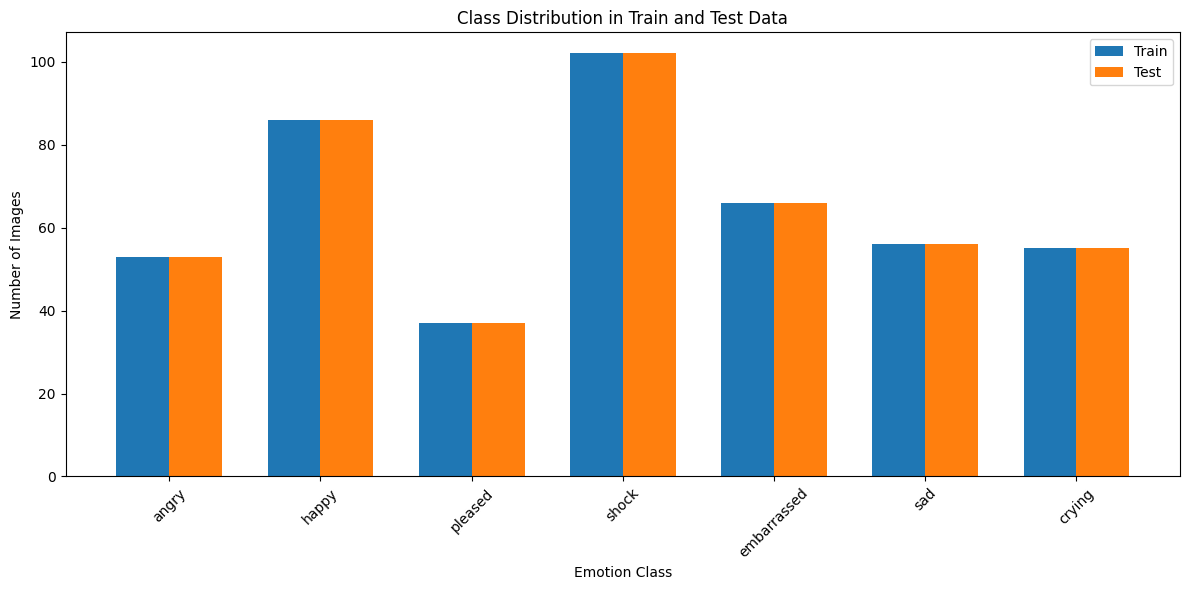

In [13]:
# Emotion class names (replace this list with your actual class names)
emotion_classes = ['angry', 'happy', 'pleased', 'shock', 'embarrassed', 'sad', 'crying']

# Function to count and plot class distributions for train and test data
def plot_class_distributions(train_labels, test_labels, emotion_classes):
    # Count class samples in training data
    train_unique_labels, train_counts = np.unique(train_labels, return_counts=True)

    # Count class samples in test data
    test_unique_labels, test_counts = np.unique(test_labels, return_counts=True)

    # Ensure labels are sorted by class (based on emotion classes)
    emotion_class_dict = {i: emotion_classes[i] for i in range(len(emotion_classes))}

    # Plot the distributions
    x = np.arange(len(train_unique_labels))  # Label positions
    width = 0.35  # Bar width

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, train_counts, width, label='Train')
    plt.bar(x + width/2, test_counts, width, label='Test')

    # Set the labels for x-axis as the class names
    plt.xlabel('Emotion Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Train and Test Data')
    plt.xticks(x, [emotion_class_dict[label] for label in train_unique_labels], rotation=45)  # Show class names
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function with the train and test labels and the emotion class names
plot_class_distributions(train_labels, test_labels, emotion_classes)


In [14]:
# Function to calculate image statistics
def image_statistics(images):
    # Flatten the images into one large array (i.e., all pixels in all images)
    all_pixels = images.flatten()

   # Calculate statistics
    mean_pixel_value = np.mean(all_pixels) #Corrected indentation
    std_pixel_value = np.std(all_pixels) #Corrected indentation
    max_pixel_value = np.max(all_pixels) #Corrected indentation
    min_pixel_value = np.min(all_pixels) #Corrected indentation

    print(f"Mean pixel value: {mean_pixel_value:.2f}")
    print(f"Standard deviation of pixel values: {std_pixel_value:.2f}")
    print(f"Max pixel value: {max_pixel_value:.2f}")
    print(f"Min pixel value: {min_pixel_value:.2f}")

# Load training and testing data using the get_data function
train_images, train_labels = get_data(train_path)
test_images, test_labels = get_data(test_path)

# Call the function for the training data
print("Training Data Statistics:")
image_statistics(train_images)

# Call the function for the testing data
print("\nTesting Data Statistics:")
image_statistics(test_images)



Training Data Statistics:
Mean pixel value: 194.25
Standard deviation of pixel values: 80.90
Max pixel value: 255.00
Min pixel value: 0.00

Testing Data Statistics:
Mean pixel value: 194.25
Standard deviation of pixel values: 80.90
Max pixel value: 255.00
Min pixel value: 0.00


In [15]:
# Calculate and print the class distribution in percentages
def class_percentage_distribution(labels, counts, total_samples):
    for label, count in zip(labels, counts):
        percentage = (count / total_samples) * 100
        print(f"Class: {label}, Count: {count}, Percentage: {percentage:.2f}%")

# Get the total number of images in the training set
train_counts = np.unique(train_labels, return_counts=True)[1]  # Get counts for training data
total_train_samples = len(train_path)  # Total training samples

# Call the function for the training data
class_percentage_distribution(labels, train_counts, total_train_samples)

# Get the total number of images in the testing set
test_counts = np.unique(test_labels, return_counts=True)[1]  # Get counts for testing data
total_test_samples = len(test_path)  # Total testing samples

# Call the function for the testing data
class_percentage_distribution(labels, test_counts, total_test_samples)


Class: angry, Count: 53, Percentage: 70.67%
Class: happy, Count: 86, Percentage: 114.67%
Class: pleased, Count: 37, Percentage: 49.33%
Class: shock, Count: 102, Percentage: 136.00%
Class: embarrassed, Count: 66, Percentage: 88.00%
Class: sad, Count: 56, Percentage: 74.67%
Class: crying, Count: 55, Percentage: 73.33%
Class: angry, Count: 53, Percentage: 70.67%
Class: happy, Count: 86, Percentage: 114.67%
Class: pleased, Count: 37, Percentage: 49.33%
Class: shock, Count: 102, Percentage: 136.00%
Class: embarrassed, Count: 66, Percentage: 88.00%
Class: sad, Count: 56, Percentage: 74.67%
Class: crying, Count: 55, Percentage: 73.33%


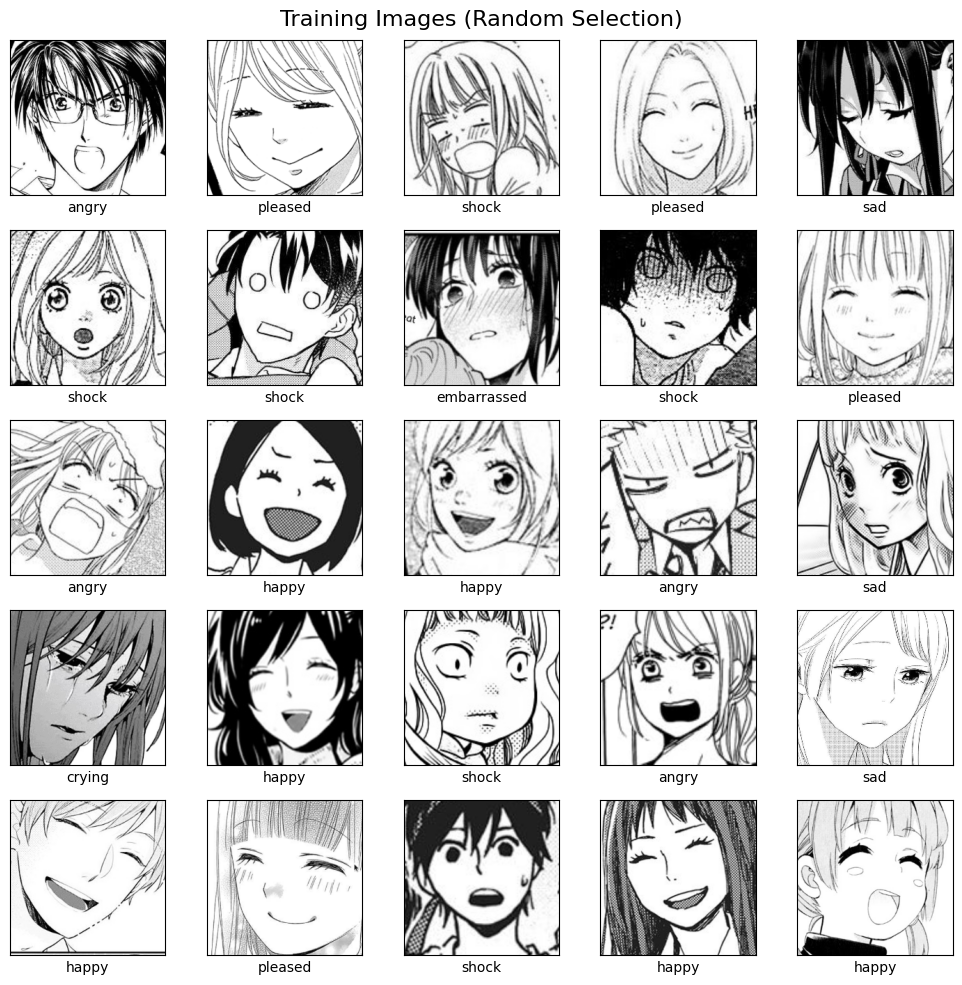

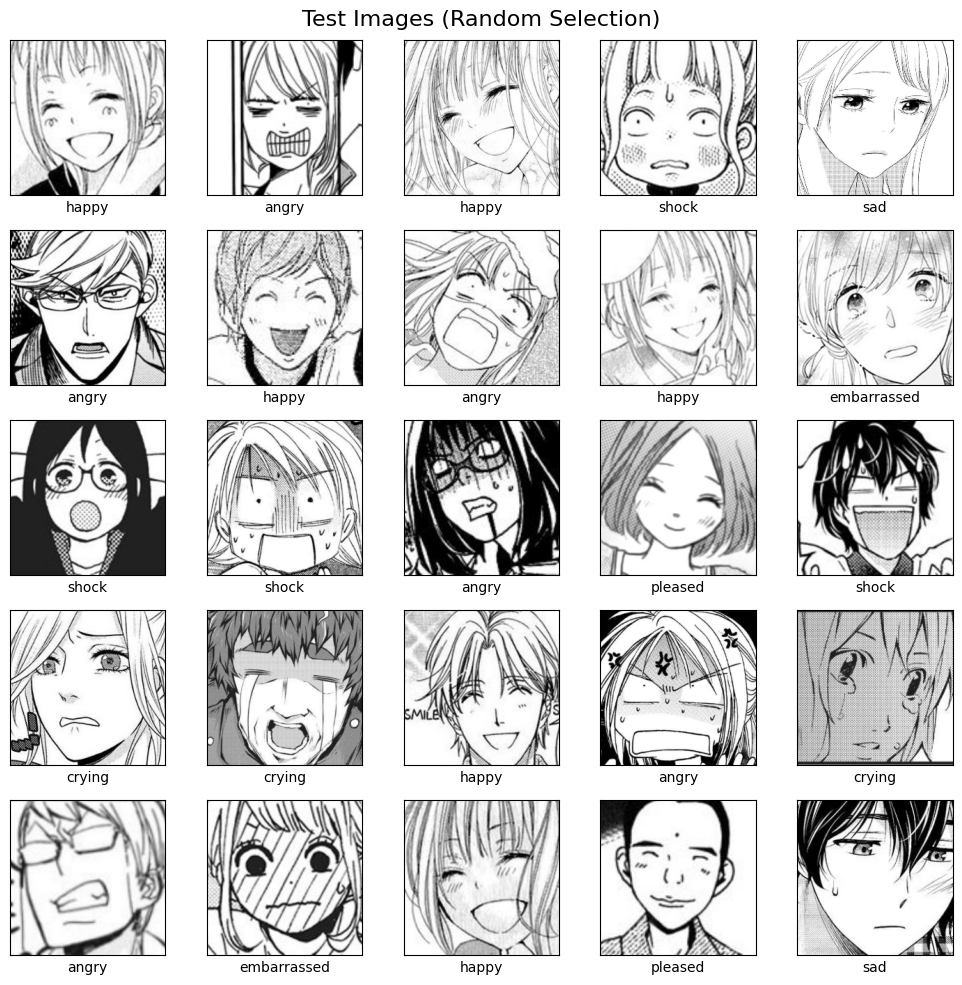

In [16]:
# Define the class names
class_names = ['angry', 'happy', 'pleased', 'shock', 'embarrassed', 'sad', 'crying']

# Load the training and testing data using the `get_data` function
train_images, train_labels = get_data(train_path)
test_images, test_labels = get_data(test_path)

# Function to display random images
def show_random_images(images, labels, class_names, num_images=25, title="Random Images"):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        random_index = random.randint(0, len(images) - 1)  # Get a random index

        # Plot the image
        plt.subplot(5, 5, i + 1)
        plt.xticks([])  # Hide x ticks
        plt.yticks([])  # Hide y ticks
        plt.grid(False)  # Turn off the grid
        plt.imshow(images[random_index])  # Display the randomly selected image
        plt.xlabel(class_names[labels[random_index]])  # Label with the corresponding class

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 25 random images from the training set
show_random_images(train_images, train_labels, class_names, title="Training Images (Random Selection)")

# Show 25 random images from the testing set
show_random_images(test_images, test_labels, class_names, title="Test Images (Random Selection)")


## Image Generator

In [17]:
train_images = train_images / 255.0
test_images = test_images / 255.0


In [18]:
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)


In [19]:
# Define data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,  # Shearing transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Filling in missing pixels after transformations
)

# For testing/validation, we only rescale the images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path to the training and testing directories (replace with your actual paths)
train_path = '/root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1'  # Update this path
test_path = '/root/.cache/kagglehub/datasets/mertkkl/manga-facial-expressions/versions/1'  # Update this path

# Setup the training data generator
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the training directory
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,  # Number of images to process per batch
    class_mode='categorical',  # Multi-class classification
    shuffle=True  # Shuffle the training data
)

# Setup the testing data generator
test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to the testing directory
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,  # Number of images to process per batch
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # Don't shuffle the test data
)


Found 455 images belonging to 7 classes.
Found 455 images belonging to 7 classes.


## Pre-Build Models

### VGG16 Model

In [20]:
# Load VGG16 base model with pre-trained weights
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers except the last few for fine-tuning
vgg16_base.trainable = True
fine_tune_at = 15  # Fine-tune from the 15th layer onward
for layer in vgg16_base.layers[:fine_tune_at]:
    layer.trainable = False  # Freeze layers before the fine-tuning point

# Build the custom model
vgg_model = models.Sequential([
    vgg16_base,  # Base VGG16 model
    GlobalAveragePooling2D(),  # Global average pooling to reduce feature map dimensions
    BatchNormalization(),  # Batch normalization for stable training
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Fully connected layer with L2 regularization
    Dropout(0.5),  # Dropout for regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Additional fully connected layer
    Dropout(0.3),  # Dropout for additional regularization
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

# Compile the model with a fine-tuning friendly learning rate
vgg_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Fine-tuning learning rate
    loss='categorical_crossentropy',  # Loss for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

# Print model summary to confirm architecture
vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,881,863 (56.77 MB)

 Trainable params: 7,245,575 (27.64 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

### EfficientNetB3 Model

In [44]:
# Load EfficientNetB3 with pre-trained weights (ImageNet) and exclude the top layers
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune from a specific layer to reduce training time and prevent overfitting
fine_tune_at = 100  # Fine-tune from this layer onward

# Freeze layers before the fine-tuning layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create the full model by adding custom layers
b3_model = models.Sequential([
    base_model,  # Base EfficientNetB3 model
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a vector
    layers.BatchNormalization(),  # Normalize activations for stable training
    layers.Dense(256, activation='relu', kernel_regularizer='l2'),  # Fully connected layer with L2 regularization
    layers.Dropout(0.4),  # Dropout to reduce overfitting
    layers.Dense(128, activation='relu', kernel_regularizer='l2'),  # Another fully connected layer
    layers.Dropout(0.4),  # Dropout to reduce overfitting
    layers.Dense(7, activation='softmax')  # Output layer for 7 classes (adjust based on your dataset)
])

# Learning rate scheduler with a smooth decay function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep the learning rate constant for the first 10 epochs
    else:
        return lr * 0.9  # Reduce learning rate by 10% every epoch

# Callbacks for robust training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 5
    patience=3,  # Wait for 3 epochs of no improvement
    min_lr=1e-7,  # Set a minimum learning rate
    verbose=1
)

# Compile the model
b3_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Use a slightly higher learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
b3_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,216,950 (42.79 MB)

 Trainable params: 11,006,285 (41.99 MB)

 Non-trainable params: 210,665 (822.91 KB)

### MobileNetV2

In [43]:
# Load MobileNetV2 with pre-trained weights and exclude top layers for transfer learning
base_model_mnv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune starting at a specific layer to reduce overfitting
fine_tune_at = 100  # Fine-tune from this layer onward

# Freeze all layers before the fine-tuning point
for layer in base_model_mnv2.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom classification layers on top of MobileNetV2
mnv2_model = models.Sequential([
    base_model_mnv2,  # Base model (MobileNetV2)
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector
    layers.BatchNormalization(),  # Normalize to stabilize training
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(7, activation='softmax')  # Output layer for 7 classes
])

# Compile the model with a small learning rate suitable for fine-tuning
mnv2_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Slightly higher learning rate for better convergence
    loss='categorical_crossentropy',  # Multi-class classification loss
    metrics=['accuracy']  # Monitor accuracy
)

# Display the model architecture
mnv2_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,624,839 (10.01 MB)

 Trainable params: 2,225,735 (8.49 MB)

 Non-trainable params: 399,104 (1.52 MB)

In [23]:
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',  # Stop if validation loss doesn't improve
    patience=3,  # Wait for 3 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half
    patience=2,  # Wait for 2 epochs without improvement
    min_lr=1e-7,  # Minimum learning rate
    verbose=1  # Log learning rate reduction
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_vgg_model.keras',  # Save model to this file
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only when val_loss improves
    verbose=1
)

# Train the model without invalid arguments
vgg_history = vgg_model.fit(
    train_generator,  # Training data generator
    validation_data=test_generator,  # Validation data generator
    epochs=30, # Lower epochs to speed up training
    batch_size=64,  # Batch size
    callbacks=[early_stop, lr_reduce, model_checkpoint],  # Add ModelCheckpoint callback
    verbose=1  # Show training progress
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1574 - loss: 2.8438 
Epoch 1: val_loss improved from inf to 2.50641, saving model to best_vgg_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 569s 38s/step - accuracy: 0.1583 - loss: 2.8398 - val_accuracy: 0.1692 - val_loss: 2.5064 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2037 - loss: 2.4723 
Epoch 2: val_loss improved from 2.50641 to 2.41761, saving model to best_vgg_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 636s 39s/step - accuracy: 0.2036 - loss: 2.4737 - val_accuracy: 0.2264 - val_loss: 2.4176 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.3235 - loss: 2.2876 
Epoch 3: val_loss improved from 2.41761 to 2.33093, saving model to best_vgg_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 614s 39s/step - accuracy: 0.3244 - loss: 2.2868 - val_accuracy: 0.3538 - val_loss: 2.3309 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accura

In [45]:
# Train the model
b3_history = b3_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,  # Train for up to 30 epochs
    batch_size=64,
    callbacks=[checkpoint, reduce_lr],  # Use callbacks for early stopping and learning rate reduction
    verbose=1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1589 - loss: 8.9825
Epoch 1: val_loss did not improve from 7.37573
15/15 ━━━━━━━━━━━━━━━━━━━━ 284s 14s/step - accuracy: 0.1589 - loss: 8.9763 - val_accuracy: 0.1890 - val_loss: 7.9978 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1698 - loss: 8.7945
Epoch 2: val_loss did not improve from 7.37573
15/15 ━━━━━━━━━━━━━━━━━━━━ 210s 14s/step - accuracy: 0.1692 - loss: 8.7968 - val_accuracy: 0.2242 - val_loss: 7.9669 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2116 - loss: 8.5694
Epoch 3: val_loss did not improve from 7.37573
15/15 ━━━━━━━━━━━━━━━━━━━━ 261s 14s/step - accuracy: 0.2109 - loss: 8.5707 - val_accuracy: 0.2242 - val_loss: 7.9420 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2303 - loss: 8.4797 
Epoch 4: val_loss did not improve from 7.37573
15/15 ━━━━━━━━━━━━━━━━━━━━ 207s 14s/step

In [46]:
# Callbacks to enhance training
checkpoint = ModelCheckpoint(
    'best_mnv2_model.keras',  # Save the best model based on validation loss
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate by a factor of 5
    patience=3,  # Wait 3 epochs before reducing the learning rate
    min_lr=1e-7,  # Set a lower limit for the learning rate
    verbose=1
)

# Train the model
history_mnv2 = mnv2_model.fit(
    train_generator,  # Training data generator
    validation_data=test_generator,  # Validation data generator
    epochs=30,  # Train for up to 30 epochs
    batch_size=64,  # Batch size
    callbacks=[checkpoint, reduce_lr],  # Use callbacks for robust training
    verbose=1
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1652 - loss: 8.4446
Epoch 1: val_loss improved from inf to 7.83653, saving model to best_mnv2_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.1654 - loss: 8.4402 - val_accuracy: 0.2835 - val_loss: 7.8365 - learning_rate: 1.0000e-04
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2718 - loss: 7.8342
Epoch 2: val_loss improved from 7.83653 to 7.70314, saving model to best_mnv2_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.2720 - loss: 7.8358 - val_accuracy: 0.3538 - val_loss: 7.7031 - learning_rate: 1.0000e-04
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3052 - loss: 7.7807
Epoch 3: val_loss improved from 7.70314 to 7.58355, saving model to best_mnv2_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.3074 - loss: 7.7757 - val_accuracy: 0.3890 - val_loss: 7.5835 - learning_rate: 1.0000e-04
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accur

## Evaluation and Result

### Evaluate Models

In [47]:
# Dictionary to store results
results = {}

def evaluate_model(model, name, test_generator):
    if not model:
        print(f"Model {name} is not loaded.")
        return

    try:
        loss, accuracy = model.evaluate(test_generator, verbose=2)
        results[name] = (loss, accuracy)
        print(f'{name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# Evaluate models
model_names = ['MobileNetV2', 'VGG16', 'EfficientNetB3']
models = [mnv2_model, vgg_model, b3_model]

for name, model in zip(model_names, models):
    evaluate_model(model, name, test_generator)


15/15 - 17s - 1s/step - accuracy: 0.6637 - loss: 6.5619
MobileNetV2 - Test Loss: 6.5619, Test Accuracy: 0.6637
15/15 - 246s - 16s/step - accuracy: 0.9868 - loss: 0.5525
VGG16 - Test Loss: 0.5525, Test Accuracy: 0.9868
15/15 - 59s - 4s/step - accuracy: 0.3516 - loss: 7.0951
EfficientNetB3 - Test Loss: 7.0951, Test Accuracy: 0.3516


### Plot Histories

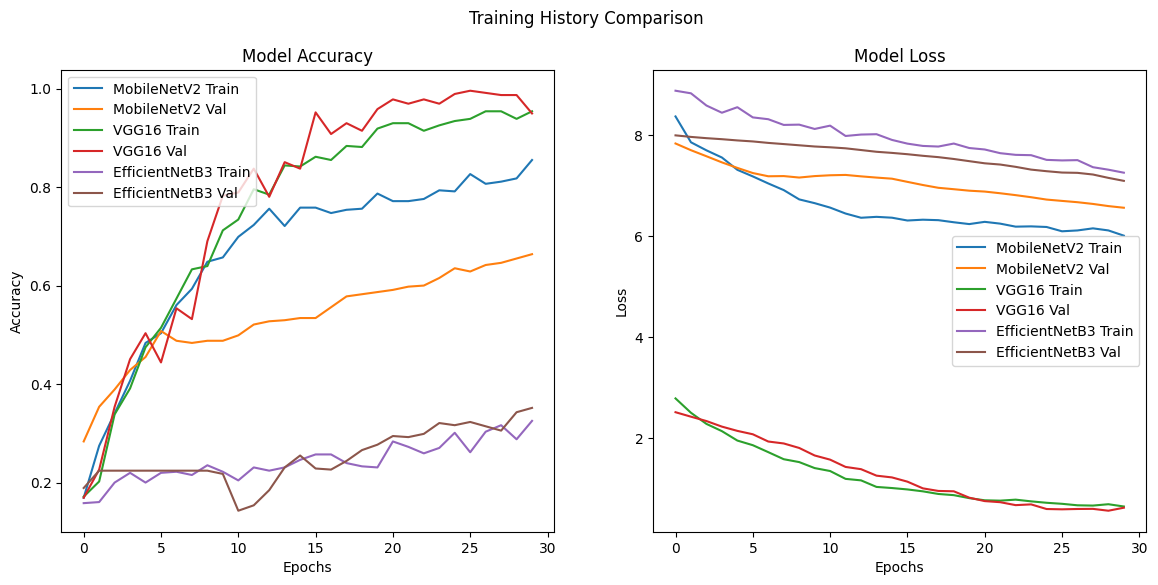

In [48]:
def plot_histories(histories):
    if not histories:
        print("No histories provided for plotting.")
        return

    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        if 'accuracy' in history.history:
            plt.plot(history.history['accuracy'], label=f'{name} Train')
            plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        if 'loss' in history.history:
            plt.plot(history.history['loss'], label=f'{name} Train')
            plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle('Training History Comparison')
    plt.show()

# Plot training histories
try:
    plot_histories({
        'MobileNetV2': history_mnv2,
        'VGG16': vgg_history,
        'EfficientNetB3': b3_history,
    })
except NameError as e:
    print(f"Error plotting histories: {e}")


### Print Evaluation Summary and Confusion Matrix

15/15 - 33s - 2s/step - accuracy: 0.6637 - loss: 6.5619
MobileNetV2 - Test Loss: 6.5619, Test Accuracy: 0.6637
15/15 - 252s - 17s/step - accuracy: 0.9868 - loss: 0.5525
VGG16 - Test Loss: 0.5525, Test Accuracy: 0.9868
15/15 - 61s - 4s/step - accuracy: 0.3516 - loss: 7.0951
EfficientNetB3 - Test Loss: 7.0951, Test Accuracy: 0.3516

Model Evaluation Results:
VGG16: Loss = 0.5525, Accuracy = 0.9868
MobileNetV2: Loss = 6.5619, Accuracy = 0.6637
EfficientNetB3: Loss = 7.0951, Accuracy = 0.3516

Confusion Matrices:


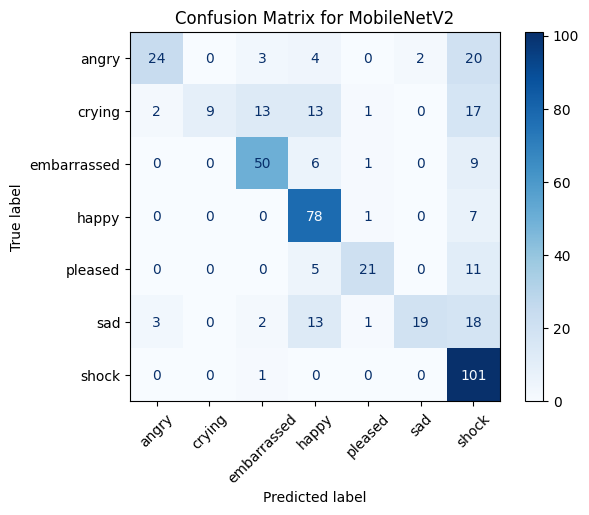

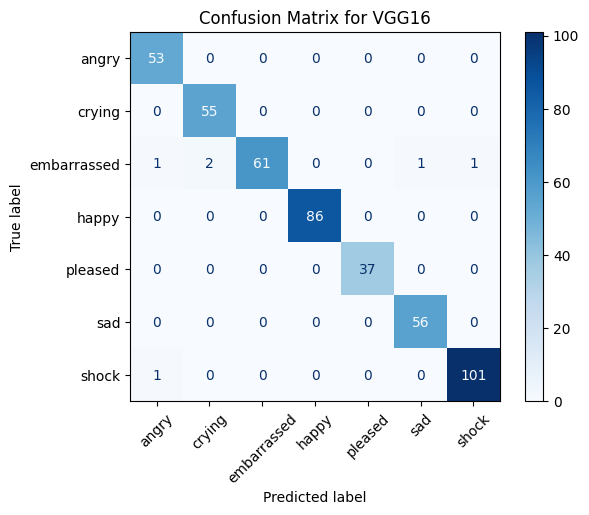

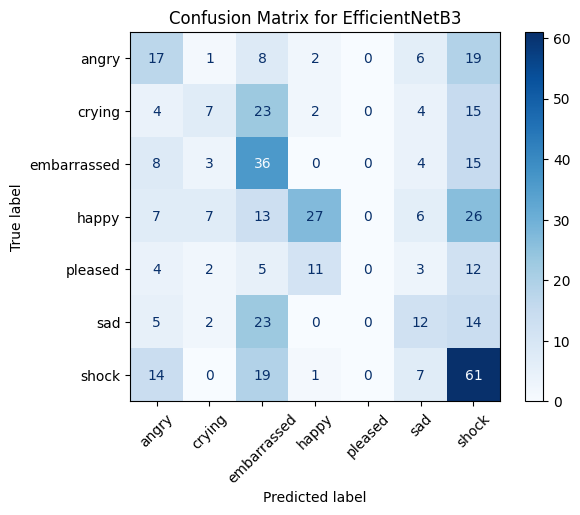

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize results as an empty list
results = []

def evaluate_model(model, name, test_generator):
    if not model:
        print(f"Model {name} is not loaded.")
        return

    try:
        loss, accuracy = model.evaluate(test_generator, verbose=2)
        # Append results as a dictionary
        results.append({'Model': name, 'Loss': loss, 'Accuracy': accuracy})
        print(f'{name} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

def print_evaluation_summary_with_confusion_matrix(results, model_names, models, test_generator):
    if not results:
        print("No evaluation results to display.")
        return

    print("\nModel Evaluation Results:")
    # Sort the results list by accuracy in descending order
    sorted_results = sorted(results, key=lambda x: x['Accuracy'], reverse=True)
    for result in sorted_results:
        print(f'{result["Model"]}: Loss = {result["Loss"]:.4f}, Accuracy = {result["Accuracy"]:.4f}')

    print("\nConfusion Matrices:")
    test_labels = test_generator.classes  # True labels
    class_names = list(test_generator.class_indices.keys())  # Class names

    for name, model in zip(model_names, models):
        try:
            # Generate predictions
            y_pred = model.predict(test_generator, verbose=0)
            y_pred_classes = y_pred.argmax(axis=1)  # Predicted class indices

            # Compute confusion matrix
            cm = confusion_matrix(test_labels, y_pred_classes)

            # Display confusion matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
            plt.title(f"Confusion Matrix for {name}")
            plt.show()
        except Exception as e:
            print(f"Error generating confusion matrix for {name}: {e}")


# Assuming models, model_names, and test_generator are defined
for model, name in zip(models, model_names):
    evaluate_model(model, name, test_generator)

print_evaluation_summary_with_confusion_matrix(results, model_names, models, test_generator)


15/15 - 20s - 1s/step - accuracy: 0.6637 - loss: 6.5619

Classification Report for MobileNetV2:

              precision    recall  f1-score   support

       angry       0.83      0.45      0.59        53
      crying       1.00      0.16      0.28        55
 embarrassed       0.72      0.76      0.74        66
       happy       0.66      0.91      0.76        86
     pleased       0.84      0.57      0.68        37
         sad       0.90      0.34      0.49        56
       shock       0.55      0.99      0.71       102

    accuracy                           0.66       455
   macro avg       0.79      0.60      0.61       455
weighted avg       0.75      0.66      0.63       455

15/15 - 249s - 17s/step - accuracy: 0.9868 - loss: 0.5525

Classification Report for VGG16:

              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        53
      crying       0.96      1.00      0.98        55
 embarrassed       1.00      0.92      0.96       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


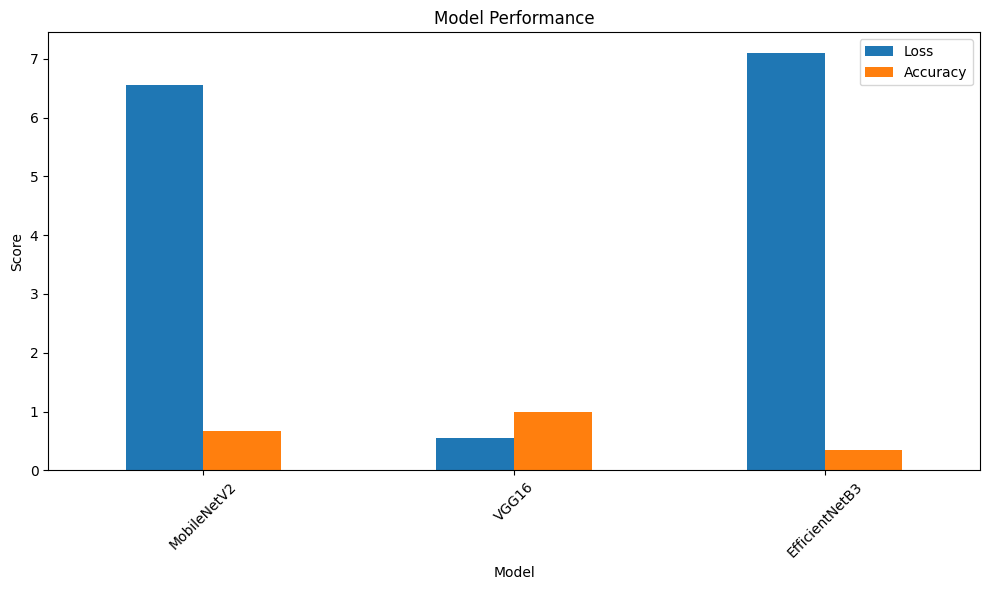

In [50]:
from sklearn.metrics import classification_report

# Define the model names and corresponding trained models
model_names = ['MobileNetV2', 'VGG16', 'EfficientNetB3']
models = [mnv2_model, vgg_model, b3_model]

# Initialize an empty list to store results
results = []

# Evaluate each model on the test set
for name, model in zip(model_names, models):
    # Evaluate the model
    loss, accuracy = model.evaluate(test_generator, verbose=2)
    results.append({'Model': name, 'Loss': loss, 'Accuracy': accuracy})

    # Generate predictions
    y_true = test_generator.classes  # True labels
    y_pred = np.argmax(model.predict(test_generator, verbose=0), axis=1)  # Predicted labels

    # Classification report
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the results
print("\nModel Evaluation Results:")
print(results_df)

# Optional: Plot the results for better visualization
results_df.set_index('Model')[['Loss', 'Accuracy']].plot(kind='bar', figsize=(10, 6), title="Model Performance")
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### The results of the models


*   MoblieNetV2
    *   Loss: 6.5619  The moderate loss indicates that the model poor performance
    *   Accuracry: 66.73% The model perform well
  * Observations:
        *  Precision: The model is good at correctly identifying emotions like "angry" (0.83), "pleased" (0.84), and "shock" (0.55).
        *   Recall: The performance done great with "shock" (0.99) and "happy" (0.91), but struggles with "crying" (0.16) and "sad" (0.55)
        *   F1: "happy" (0.76) and "shock" (0.71) was best, showing a balance between precision and recall
        *   The model show a strong precision (0.79) but a weak recall (0.60), which the model misses some emotions. Overall, the model performs decently with 0.75 precision, 0.66 recall, adn 0.63 F1-score



*   VGG16
    *   Loss: 0.5525 which indicate low in the loss indicates excellent performance
    *   Accuracy: 98.68% which nearly all predictions are correct.
    *   Observation:
        *   Preciosn, recall, and f1-scores are close to 1.0 for most classes.
        *   Outstanding for all the classes of precision, recall, and F1 score for all emotions, "happy" (1.00), "angry" (1.00), and "crying" (1.00)
        *   The 0.99 precision, 0.99 recall, 0.99 F1-score show balanced,  high performace, and high effctiveness in the model.
        



*   EfficientNetB3

    *   Loss: 7.0951: A very high loss which indicate a poor model performance
    *   Accuracy: 35.16%: Show a low accuracy, which indicare the model perform not well ovrall.
    *   Observation:
      *   Precision: The model has poor percsion, especially for "pleased" (0.00) and "crying" (0.32)
      *   Recall: The recall was poor with "crying" (0.13) and "sad" (0.21), which indicate the fail to reconginze the emotions effective
      *   F1: The precision of "happy" (0.63) and recall for "shock" (0.60) is slightly better.
      *   The model shows poor performance overall, with a macro average of 0.31 precision, 0.30 recall, and 0.28 f1-score, indicating it struggles across all classes. The weighted average is slightly better at 0.35 precision, 0.35 recall, and 0.32 f1-score, but it still reflects weak performance with no significant improvement in any specific emotion category.







VGG16 stands out as the ideal option for the final model selection due to its impressive accuracy and minimal loss during training. Given its robust performance with low loss, there's no requirement for hyperparameter tuning or cross-validation. In contrast, the MobileNetV2 model, although it achieves reasonable accuracy, has difficulties with recall in specific emotion categories, resulting in overall weaker performance compared to VGG16. Meanwhile, EfficientNetB3 underperforms significantly, exhibiting low accuracy, high loss, and low precision across most classes, rendering it inappropriate for the final evaluation.














## Final Evaluate

In [35]:
# Evaluate the model on the test set
test_loss, test_accuracy = vgg_model.evaluate(test_generator, verbose=2)

print(f"Final Evaluation Results for VGG16:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


15/15 - 287s - 19s/step - accuracy: 0.9868 - loss: 0.5525
Final Evaluation Results for VGG16:
Test Loss: 0.5525
Test Accuracy: 0.9868


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true and predicted labels
true_classes = test_generator.classes
predicted_classes = np.argmax(vgg_model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


15/15 ━━━━━━━━━━━━━━━━━━━━ 251s 17s/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        53
      crying       0.96      1.00      0.98        55
 embarrassed       1.00      0.92      0.96        66
       happy       1.00      1.00      1.00        86
     pleased       1.00      1.00      1.00        37
         sad       0.98      1.00      0.99        56
       shock       0.99      0.99      0.99       102

    accuracy                           0.99       455
   macro avg       0.99      0.99      0.99       455
weighted avg       0.99      0.99      0.99       455



<Figure size 1000x800 with 0 Axes>

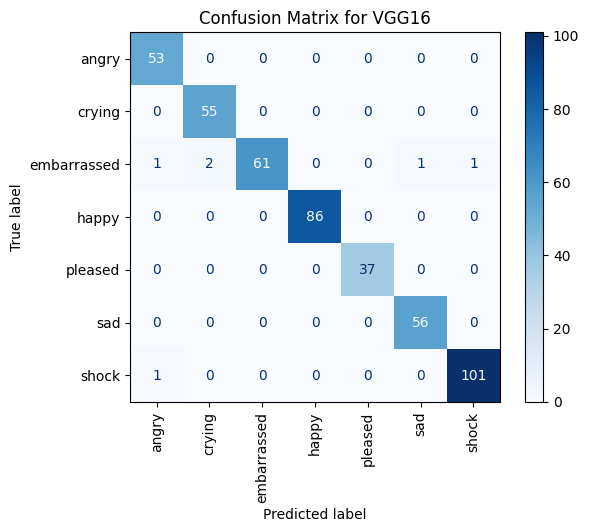

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix for VGG16")
plt.show()


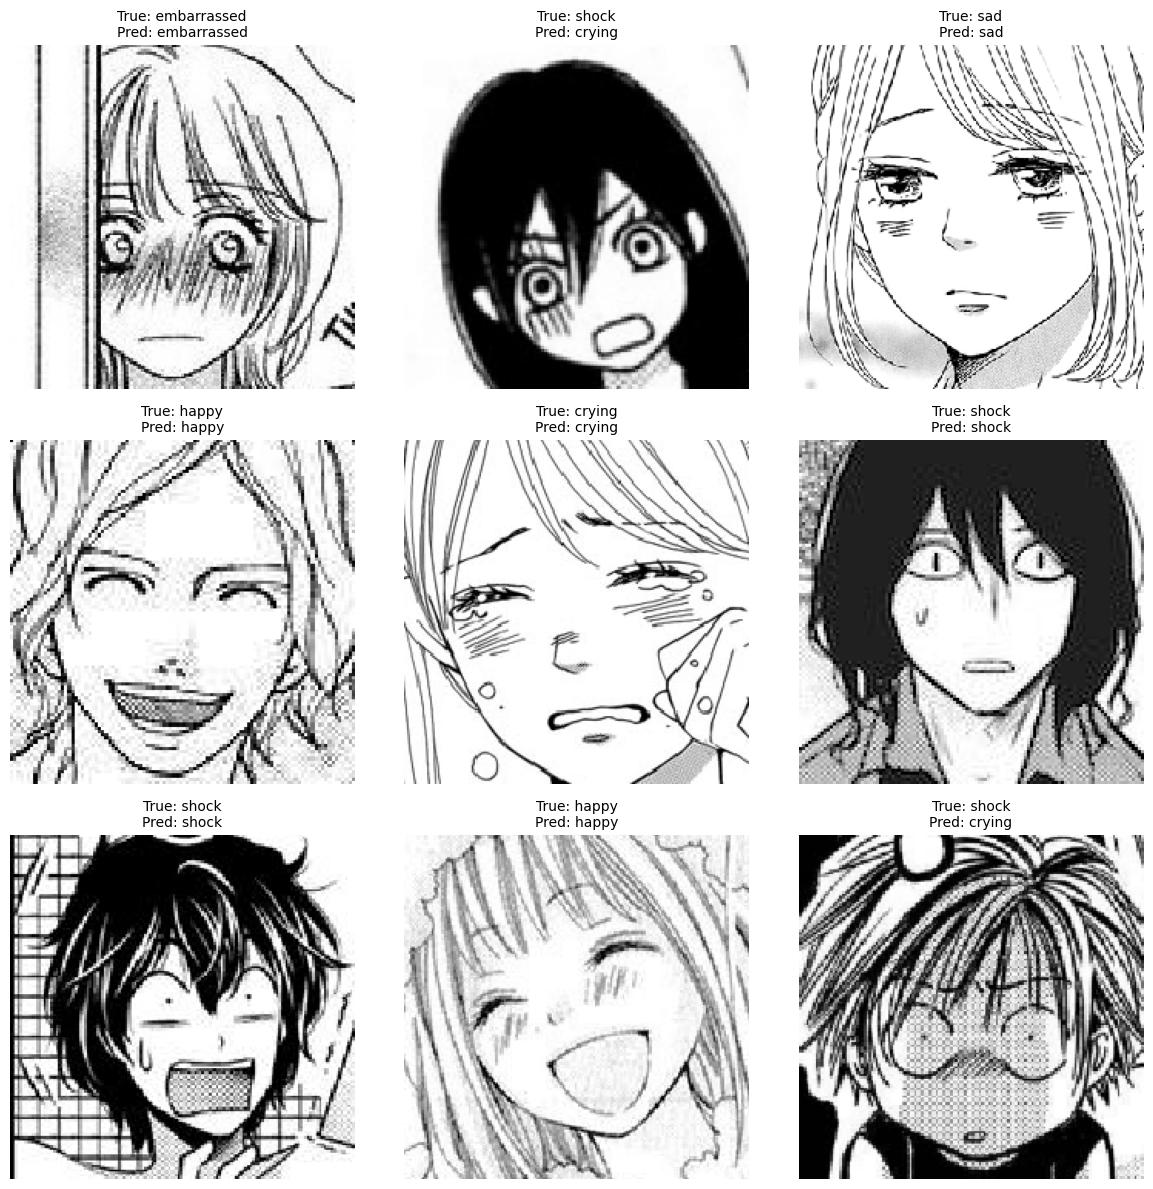

In [41]:
plt.figure(figsize=(12, 12))

# Get the total number of batches in the test generator
num_batches = len(test_generator)

# Randomly select 9 images from the test set
for i in range(9):
    # Generate a random index within the range of available batches
    idx = random.randint(0, num_batches - 1)

    # Get a batch of images and labels
    batch_images, batch_labels = test_generator[idx]

    # Select a random image from the batch
    image_idx = random.randint(0, batch_images.shape[0] - 1)
    image = batch_images[image_idx]
    label = batch_labels[image_idx]

    # Rescale the image to [0, 255] for proper visualization
    image = (image * 255).astype("uint8")

    # True and predicted labels
    true_label = class_labels[np.argmax(label)]  # Assuming one-hot encoded labels
    pred_label = class_labels[predicted_classes[idx * batch_images.shape[0] + image_idx]] # Adjust index for predicted labels

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Conclusion

In conclusion, the VGG16 model performs exceptionally well on the emotion classification task, achieving a high test accuracy of 98.68% and a low test loss of 0.5525. It excels in categories like "angry," "happy," and "shock," with precision and recall values close to 100%. However, it struggles with the "crying" category, where precision is as low as 16.36%, likely confusing it with similar emotions like "sad" or "angry." The confusion matrix supports this by showing frequent misclassifications in the "crying" class. Despite these challenges, the model's overall performance makes it a strong tool for emotion-based image classification.

# Reference

*   https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
*   https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
*   https://www.tensorflow.org/tutorials/keras/classification
*   https://www.tensorflow.org/tutorials/images/cnn
*   https://www.simplilearn.com/tutorials/deep-learning-tutorial/guide-to-building-powerful-keras-image-classification-models
*   https://www.kaggle.com/code/mpwolke/manga-facial-expressions
*   https://medium.com/@golnaz.hosseini/step-by-step-tutorial-image-classification-with-keras-7dc423f79a6b
*   https://www.kaggle.com/code/anandhuh/image-classification-using-cnn-for-beginners


